# Исследование спектра интегрального оператора

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [3]:
def fast_bbtmv_mul(col_arr,
                   row_arr,
                   vec_arr,
                   n, m, k):
    """

    :param col_arr: массив размера (n,m,k,1) где на местах по первому измерению 
    стоят элементы первого столбца трехуровневой блочно-Тёплицевой матрицы оператора, 
    где матрица представляет собой массив из n*n блоков двухуровневой блочно-Тёплицевой матрицы, 
    которые в свою очередь являются массивом из m*m блоков Тёплицевой матрицы размера k*k
    :param row_arr: массив размера (n,m,k,1) где на местах по первому измерению стоят элементы первой строки блочно-Тёплицевой матрицы оператора
    :param vec_arr: массив размера (n,m,k,1) отвечающий за вектор элементов, на которые умножается блочно-Тёплицевая матрица
    :param n: размер блоков первого уровня, определяемый дискретизацией по оси x_1
    :param m: размер блоков первого уровня, определяемый дискретизацией по оси x_2
    :param k: размер блоков первого уровня, определяемый дискретизацией по оси x_3
    :return:
    """
    
    # Создание пустого цикрулянтного тензора, который будем заполнять с помощью отражений по измерениям 
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j 

    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]

    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifft(circulant_tensor)

    return circulant_tensor[:n, :m, :k]


def prep_fftbbtensor(col_arr,
                     row_arr,
                     n, m, k):
    """

    """
    circulant_tensor = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    col_arr = col_arr.reshape((n, m, k))
    row_arr = row_arr.reshape((n, m, k))
    circulant_tensor[:n, :m, :k] = row_arr[:n, :m, :k]
    circulant_tensor[n + 1:2 * n, :m, :k] = col_arr[n:0:-1, :m, :k]
    circulant_tensor[:n, m + 1:2 * m, :k] = col_arr[:n, m:0:-1, :k]
    circulant_tensor[:n, :m, k + 1: 2 * k] = col_arr[:n, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, :k] = col_arr[n:0:-1, m:0:-1, :k]
    circulant_tensor[:n, m + 1:2 * m, k + 1:2 * k] = col_arr[:n, m:0:-1, k:0:-1]
    circulant_tensor[n + 1:2 * n, :m, k + 1:2 * k] = col_arr[n:0:-1, :m, k:0:-1]
    circulant_tensor[n + 1:2 * n, m + 1:2 * m, k + 1:2 * k] = col_arr[n:0:-1, m:0:-1, k:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    return circulant_tensor


def prep_fbbtmv(prep_fft_arr,
                vec_arr,
                n, m, k):
    """

    """
    x_arr = np.zeros((2 * n, 2 * m, 2 * k)) + 0.0j
    x_arr[:n, :m, :k] = vec_arr[:n, :m, :k]
    prep_fft_arr = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))
    return prep_fft_arr[:n, :m, :k]

# Функция трехмерной структурированной сетки центров ячеек

In [4]:
def make_grid(N, L, center, **kwargs):
    """
    
    """
    
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор, вытянутый в строку размером n*m*k
    grid = np.array(np.meshgrid(x, y, z, indexing='xy')).T.reshape(-1, 3)[:, [1, 0, 2]]
    
    return grid, volume

# Определение диэлектрической проницаемости среды

In [5]:
def step_dielectric_3d(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric_3d(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric_3d(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric_3d(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric_3d(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes

# Определение ядра интегрального оператора

$$
    B_{nm}(p-q) = \int_{\Pi_q} G(R) \left[(\frac{3}{R^2} - \frac{3ik_0}{R} - k_0^2)\alpha_n \alpha_m + (k_0^2 + \frac{ik_0}{R}-\frac{1}{R^2})\delta_{nm} \right] dy, p\ne q
$$

$$
\alpha_n = \frac{x_n(p)-y_n}{|x(p)-y|}, n=1,2,3, \quad \eta_{mk} = \varepsilon(y(q)) - \delta_{mk}, \quad R = \sqrt{\sum_{i=1}^{3} {(y_i - x_i(p))^2}}, \quad B_{nm}(0,0,0) = (-1/3)I
$$


In [6]:
def kernel(x, k=1, **kwargs):
    return np.exp(1j * k * x)/(4 * np.pi * x)

def init_operator(grid, volume, discret, distance, k, eps, kernel):
    dist_coef_1 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_1[1:] = (3 / (distance[1:] ** 2)) - ((3j * k) / distance[1:]) - (k ** 2)
    alpha = np.zeros((np.prod(discret), 3))
    alpha[1:, :] = (grid[0, :] - grid[1:, :]) / distance[1:].reshape(-1, 1)
    indexing_matrix = np.einsum('...j,...i->...ji', alpha, alpha)
    part_1 = indexing_matrix * dist_coef_1.reshape(-1, 1, 1)

    dist_coef_2 = np.zeros(np.prod(discret)) + 0.0j
    dist_coef_2[1:] = (k ** 2) + ((1j * k) / distance[1:]) - (1 / (distance[1:] ** 2))
    part_2 = np.eye(3).reshape(-1, 3, 3) * dist_coef_2.reshape(-1, 1, 1)

    gr = np.zeros(np.prod(discret)) + 0.0j
    gr[1:] = kernel(distance[1:], k)
    result = gr.reshape(-1, 1, 1) * (part_1 + part_2) * volume.reshape(-1, 1)
    eps = eps.reshape(-1, 3, 3) - (np.eye(3).reshape(-1, 3, 3))
    result[0, :, :] = -(1 / 3) * np.eye(3)
    return result, gr, eps

# Скрипт решения задачи

In [7]:
# Конфиг задачи
problem_config = {
    'N': [10, 10, 10],
    'L': [1.0, 1.0, 1.0],
    'center': [0.0, 0.0, 0.0],
    'k': 7.2,
    'orient': [0.0, 1.0, 0.0],
    'amplitude': [1.0, 0.0, 0.0],
    'sign': 1.0,
    'eps_vec': [
        {
                "type": "step",
                "eps_real": [[5.0, 0.0, 0.0],
                             [0.0, 3.0, 0.0],
                             [0.0, 0.0, 2.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 1.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
    ]
}

n_1 = problem_config.get('N')[0]
n_2 = problem_config.get('N')[1]
n_3 = problem_config.get('N')[2]
k_wave = problem_config.get('k')

grid,volume = make_grid(**problem_config)
eta, ind = apply_dielectric_3d(grid, **problem_config)
dists = np.linalg.norm(grid[0, :] - grid[:,:], 2, axis=1)
G, gr, eps = init_operator(grid, volume, problem_config.get('N'), dists, problem_config.get('k'), eta, kernel)

In [8]:
G.shape

(1000, 3, 3)

In [9]:
def make_block_toeplitz_matrix(row, col):
    result = np.zeros((col.shape[0], row.shape[0], 3, 3)) + 0.0j
    for i in np.arange(result.shape[0]-1):
        for j in np.arange(i, result.shape[1]):
            result[i, j] = row[j-i]
            result[j, i] = col[j-i]
    return result

# Предположим, что arr имеет форму (n, n, m, m)
def block_matrix(arr):
    """
    Превращает 4D-массив arr размером (n, n, m, m)
    в блочную матрицу размером (n*m, n*m).
    """
    # Переставляем оси:
    #   из (n, n, m, m) → (n, m, n, m)
    # Затем схлопываем в (n*m, n*m).
    n, _, m, _ = arr.shape
    return arr.transpose(0, 2, 1, 3).reshape(n*m, n*m)

In [10]:
eta.shape

(1000, 3, 3)

In [11]:
Matrix_G = make_block_toeplitz_matrix(G, G)

In [12]:
Matrix_G = (Matrix_G * eta.reshape(1, -1, 3, 3))

In [13]:
Matrix_G[2,2]

array([[-1.66666667+0.j, -0.        +0.j, -0.        +0.j],
       [-0.        +0.j, -1.        +0.j, -0.        +0.j],
       [-0.        +0.j, -0.        +0.j, -0.66666667+0.j]])

In [14]:
Matrix_G = block_matrix(Matrix_G) 
Matrix_G = np.eye(Matrix_G.shape[0]) - Matrix_G

In [15]:
eigvalues = np.linalg.eigvals(Matrix_G)

In [16]:
eigvalues[:10]

array([-0.09263123-5.4866749j , -2.63776865-2.81748929j,
        0.65086984-5.06247393j,  6.87392135+0.05792459j,
        6.67711371-0.37576214j,  6.71335216+0.06160888j,
        6.71281785+0.06152567j, -2.67040735-0.90551503j,
        6.50045797-0.3860084j ,  6.49927007-0.38540253j])

In [17]:
eigvalues[-10:]

array([1.89036135+0.06644169j, 1.88994357+0.06638989j,
       1.87636033+0.0683873j , 1.87666363+0.06893649j,
       1.95273291+0.07056915j, 1.9528548 +0.07062406j,
       1.95299555+0.07182612j, 1.95295198+0.07180646j,
       1.87656732+0.06880459j, 1.87643675+0.06839523j])

In [18]:
np.min(np.abs(eigvalues))

0.05482101591104004

In [19]:
np.min(np.real(eigvalues))

-2.6704073494816702

In [20]:
np.min(np.imag(eigvalues))

-5.486674903981996

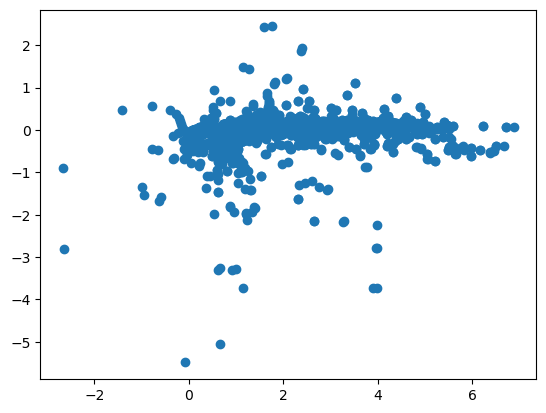

In [21]:
plt.scatter(eigvalues.real, eigvalues.imag)

In [22]:
points = np.random.rand(100)

In [31]:
p1 = np.array([1,1,1])
p2 = np.array([2,2,2])
np.linalg.norm(p1-p2, 1)

3.0